### Image classification project using the CIFAR-100 Dataset

In [314]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np

### Data set
* For this project I will be using the CIFAR-100 Dataset
* 60,000 images in total - 100 classes, 600 images per class,  10,000 test images and 50,000 training images

In [406]:
# Mean and std for CIFAR-100
mean = (0.5071, 0.4865, 0.4409)
std = (0.2673, 0.2564, 0.2762)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=transform_train,
    target_transform=None
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=transform_test,
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [407]:
def unnormalize_img(img, mean, std):
        """Unnormalize a tensor image."""
        mean = torch.tensor(mean).view(1, 1, -1)
        std = torch.tensor(std).view(1, 1, -1)
        return img * std + mean


In [408]:
image, label = train_data[0]

In [409]:
class_names = train_data.classes
class_names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [410]:
class_to_idx = train_data.class_to_idx

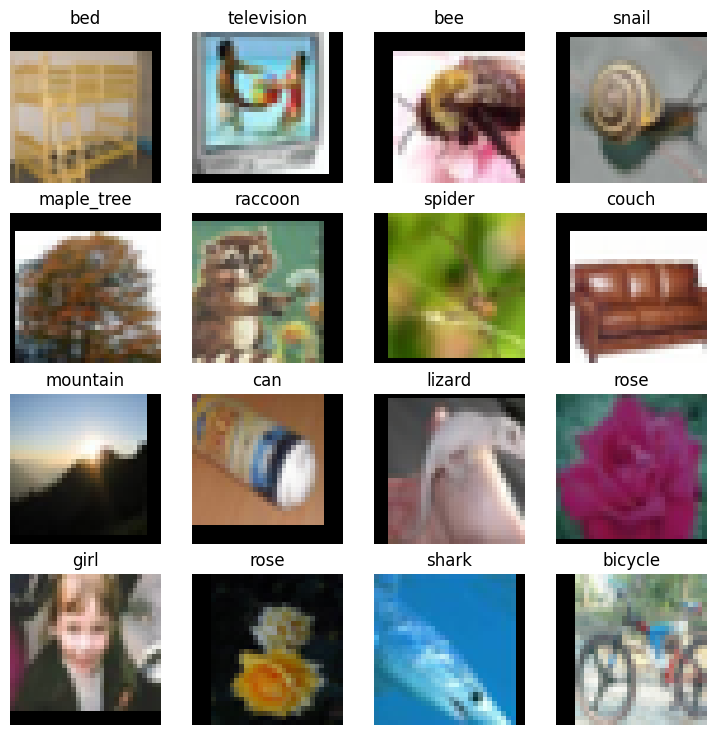

In [411]:
# Plotting some examples of the data in gray scale
torch.manual_seed(0)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    img = unnormalize_img(img.permute(1, 2, 0), mean, std)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)


### Preparing the DataLoader
* Convert the data into a python iterable, and batches

In [412]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [413]:
print(len(train_dataloader), len(test_dataloader))

1563 313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.897426..1.9958613].


Image size: torch.Size([32, 32, 3])
Label: 89, label size torch.Size([])


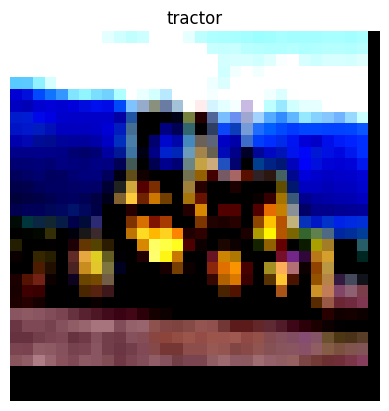

In [414]:
# Example 
train_features_batch, train_labels_batch = next(iter(train_dataloader))

rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size {label.shape}")

### Setting up the model 

* Model attempt 1 was using only linear and ReLU layers, however for this model we will attempt another approach
* This model will use Convolutional layers

In [415]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Custom training and test step functions for later use

In [416]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler, 
               accuracy_fn,
               device: torch.device = device):
    """Performs a training with model traing to learn on data_loader"""
    train_loss , train_acc = 0, 0 

    model.train()

    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss 
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # from logits -> prediction labels
        

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    scheduler.step()
    # average out train loss over all the train data
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}")

In [417]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs a testing with model traing to learn on data_loader"""

    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, 
                                    y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f} | Test acc {test_acc:.2f}")

In [425]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        # Global average pooling
        y = self.global_avg_pool(x).view(batch_size, channels)
        # Fully connected layers with reduction
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch_size, channels, 1, 1)
        # Scale the input features
        return x * y

class ResidualSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=0.3)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SqueezeExcitationBlock(out_channels, reduction)

        # Shortcut connection
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) \
                        if in_channels != out_channels or stride != 1 else nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)  # Apply SE block
        return nn.ReLU()(x + shortcut)

class CIFAR100Model(nn.Module):
    def __init__(self, input_shape: int, width_multiplier: int, num_classes: int):
        super().__init__()
        
        # Stem stage for initial feature extraction
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        # Stage 1
        self.stage1 = self._make_stage(16, 16 * width_multiplier, num_blocks=2, stride=1)
        
        # Stage 2
        self.stage2 = self._make_stage(16 * width_multiplier, 32 * width_multiplier, num_blocks=2, stride=2)
        
        # Stage 3
        self.stage3 = self._make_stage(32 * width_multiplier, 64 * width_multiplier, num_blocks=2, stride=2)
        
        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(64 * width_multiplier, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            layers.append(
                ResidualSEBlock(
                    in_channels=in_channels if i == 0 else out_channels,
                    out_channels=out_channels,
                    stride=stride if i == 0 else 1
                )
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x) 
        x = self.fc(x)
        return x

In [426]:
torch.manual_seed(0)
model = CIFAR100Model(input_shape=3, 
                      width_multiplier=10,
                      num_classes=len(class_names)).to(device)
model

CIFAR100Model(
  (stem): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (stage1): Sequential(
    (0): ResidualSEBlock(
      (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SqueezeExcitationBlock(
        (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Linear(in_features=160, out_features=10, bias=True)
        (relu): ReLU()
        (fc2): Linear(in_features=10, out_features=160, bias=True)
        (sigmoid): Sigmoid()
      )
    

#### Calculating what number of in_features needed for our classifier layer

In [427]:
import torch.nn.functional as F

rand_image_tensor_resized = F.interpolate(rand_image_tensor.unsqueeze(0), size=(32, 32), mode='bilinear')

rand_image_tensor_rgb = rand_image_tensor_resized.repeat(1, 3, 1, 1) 

output = model(rand_image_tensor_rgb.to(device))
print(output.shape) 


torch.Size([1, 100])


### Setting up a loss function and optimizer
* Accuracy
* Cross Entropy Loss - Multi-class Classification
* Stochastic gradient descent

In [428]:
def accuracy_fn(y_true, y_pred):
    """
    Calculates accuracy between truth labels and predictions.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [429]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)


In [430]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [431]:
X, y = next(iter(train_dataloader))  # Get a batch of data
X = X.to(device)
output = model(X)  # Pass through the model
print(output.shape)  # Should be [batch_size, 100] for CIFAR-100


torch.Size([32, 100])


In [449]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)

from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_model_start_2 = timer()
epochs = 115

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               scheduler=scheduler,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

train_time_model_end_2 = timer()

total_train_time_model_2 = print_train_time(start=train_time_model_start_2,
                                            end=train_time_model_end_2,
                                            device=device)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 0
Train loss: 1.03863 | Train acc: 95.83


  1%|          | 1/115 [03:57<7:32:00, 237.90s/it]

Test loss: 1.7165 | Test acc 71.87
Epoch 1
Train loss: 1.03888 | Train acc: 95.78


  2%|▏         | 2/115 [07:56<7:28:33, 238.18s/it]

Test loss: 1.7212 | Test acc 71.74
Epoch 2
Train loss: 1.02515 | Train acc: 96.27


  3%|▎         | 3/115 [11:55<7:25:14, 238.52s/it]

Test loss: 1.7171 | Test acc 72.14
Epoch 3
Train loss: 1.01571 | Train acc: 96.68


  3%|▎         | 4/115 [15:54<7:21:38, 238.72s/it]

Test loss: 1.7033 | Test acc 71.70
Epoch 4
Train loss: 1.00651 | Train acc: 96.94


  4%|▍         | 5/115 [19:52<7:17:40, 238.73s/it]

Test loss: 1.7081 | Test acc 72.15
Epoch 5
Train loss: 0.99933 | Train acc: 97.16


  5%|▌         | 6/115 [23:51<7:13:38, 238.71s/it]

Test loss: 1.7074 | Test acc 72.14
Epoch 6
Train loss: 0.99083 | Train acc: 97.43


  6%|▌         | 7/115 [27:50<7:09:31, 238.63s/it]

Test loss: 1.7065 | Test acc 71.88
Epoch 7
Train loss: 0.98417 | Train acc: 97.70


  7%|▋         | 8/115 [31:48<7:05:37, 238.67s/it]

Test loss: 1.7055 | Test acc 72.05
Epoch 8
Train loss: 0.97618 | Train acc: 97.94


  8%|▊         | 9/115 [35:47<7:01:38, 238.67s/it]

Test loss: 1.7029 | Test acc 72.16
Epoch 9
Train loss: 0.97030 | Train acc: 98.15


  9%|▊         | 10/115 [39:45<6:57:30, 238.58s/it]

Test loss: 1.7016 | Test acc 72.08
Epoch 10
Train loss: 0.96695 | Train acc: 98.23


 10%|▉         | 11/115 [43:44<6:53:36, 238.62s/it]

Test loss: 1.6999 | Test acc 72.23
Epoch 11
Train loss: 0.96262 | Train acc: 98.28


 10%|█         | 12/115 [47:43<6:49:38, 238.63s/it]

Test loss: 1.6976 | Test acc 72.23
Epoch 12
Train loss: 0.95840 | Train acc: 98.53


 11%|█▏        | 13/115 [51:41<6:45:38, 238.61s/it]

Test loss: 1.6980 | Test acc 72.21
Epoch 13
Train loss: 0.95429 | Train acc: 98.60


 12%|█▏        | 14/115 [55:40<6:41:36, 238.58s/it]

Test loss: 1.6974 | Test acc 72.38
Epoch 14
Train loss: 0.95143 | Train acc: 98.72


 13%|█▎        | 15/115 [59:38<6:37:34, 238.54s/it]

Test loss: 1.6992 | Test acc 72.45
Epoch 15
Train loss: 0.94786 | Train acc: 98.69


 14%|█▍        | 16/115 [1:03:37<6:33:30, 238.49s/it]

Test loss: 1.6989 | Test acc 72.38
Epoch 16
Train loss: 0.94514 | Train acc: 98.81


 15%|█▍        | 17/115 [1:07:35<6:29:36, 238.54s/it]

Test loss: 1.6981 | Test acc 72.26
Epoch 17
Train loss: 0.94309 | Train acc: 98.90


 16%|█▌        | 18/115 [1:11:34<6:25:46, 238.62s/it]

Test loss: 1.7023 | Test acc 72.22
Epoch 18
Train loss: 0.94085 | Train acc: 98.96


 17%|█▋        | 19/115 [1:15:33<6:21:47, 238.62s/it]

Test loss: 1.6986 | Test acc 72.03
Epoch 19
Train loss: 0.93710 | Train acc: 99.03


 17%|█▋        | 20/115 [1:19:31<6:17:43, 238.57s/it]

Test loss: 1.6975 | Test acc 72.45
Epoch 20
Train loss: 0.93662 | Train acc: 98.96


 18%|█▊        | 21/115 [1:23:30<6:13:47, 238.59s/it]

Test loss: 1.6982 | Test acc 72.30
Epoch 21
Train loss: 0.93210 | Train acc: 99.16


 19%|█▉        | 22/115 [1:27:29<6:09:54, 238.65s/it]

Test loss: 1.6980 | Test acc 72.27
Epoch 22
Train loss: 0.93066 | Train acc: 99.28


 20%|██        | 23/115 [1:31:27<6:05:53, 238.62s/it]

Test loss: 1.7071 | Test acc 72.33
Epoch 23
Train loss: 0.92723 | Train acc: 99.29


 21%|██        | 24/115 [1:35:26<6:01:54, 238.62s/it]

Test loss: 1.7020 | Test acc 72.36
Epoch 24
Train loss: 0.92604 | Train acc: 99.31


 22%|██▏       | 25/115 [1:39:24<5:57:57, 238.64s/it]

Test loss: 1.7028 | Test acc 72.46
Epoch 25
Train loss: 0.92315 | Train acc: 99.37


 23%|██▎       | 26/115 [1:43:23<5:53:56, 238.62s/it]

Test loss: 1.7065 | Test acc 72.23
Epoch 26
Train loss: 0.92141 | Train acc: 99.43


 23%|██▎       | 27/115 [1:47:22<5:49:56, 238.60s/it]

Test loss: 1.7123 | Test acc 72.12
Epoch 27
Train loss: 0.92050 | Train acc: 99.42


 24%|██▍       | 28/115 [1:51:20<5:45:59, 238.61s/it]

Test loss: 1.7201 | Test acc 72.16
Epoch 28
Train loss: 0.92054 | Train acc: 99.44


 25%|██▌       | 29/115 [1:55:19<5:41:57, 238.57s/it]

Test loss: 1.7312 | Test acc 71.50
Epoch 29
Train loss: 0.92107 | Train acc: 99.43


 26%|██▌       | 30/115 [1:59:18<5:38:04, 238.64s/it]

Test loss: 1.7349 | Test acc 71.26
Epoch 30
Train loss: 0.92215 | Train acc: 99.42


 27%|██▋       | 31/115 [2:03:16<5:34:03, 238.61s/it]

Test loss: 1.7416 | Test acc 71.48
Epoch 31
Train loss: 0.92203 | Train acc: 99.47


 28%|██▊       | 32/115 [2:07:14<5:30:00, 238.56s/it]

Test loss: 1.7434 | Test acc 71.30
Epoch 32
Train loss: 0.92797 | Train acc: 99.32


 29%|██▊       | 33/115 [2:11:13<5:26:04, 238.60s/it]

Test loss: 1.7502 | Test acc 71.28
Epoch 33
Train loss: 0.93481 | Train acc: 99.21


 30%|██▉       | 34/115 [2:15:12<5:21:59, 238.52s/it]

Test loss: 1.7526 | Test acc 70.89
Epoch 34
Train loss: 0.94161 | Train acc: 99.00


 30%|███       | 35/115 [2:19:10<5:18:07, 238.59s/it]

Test loss: 1.7616 | Test acc 71.06
Epoch 35
Train loss: 1.03481 | Train acc: 95.30


 31%|███▏      | 36/115 [2:23:09<5:14:04, 238.54s/it]

Test loss: 1.7523 | Test acc 71.17
Epoch 36
Train loss: 1.02593 | Train acc: 95.68


 32%|███▏      | 37/115 [2:27:07<5:10:09, 238.59s/it]

Test loss: 1.7512 | Test acc 71.25
Epoch 37
Train loss: 1.02505 | Train acc: 95.79


 33%|███▎      | 38/115 [2:31:06<5:06:09, 238.57s/it]

Test loss: 1.7611 | Test acc 71.13
Epoch 38
Train loss: 1.02989 | Train acc: 95.58


 34%|███▍      | 39/115 [2:35:04<5:02:10, 238.56s/it]

Test loss: 1.7590 | Test acc 70.55
Epoch 39
Train loss: 1.03324 | Train acc: 95.36


 35%|███▍      | 40/115 [2:39:03<4:58:17, 238.63s/it]

Test loss: 1.7733 | Test acc 70.87
Epoch 40
Train loss: 1.03807 | Train acc: 95.18


 36%|███▌      | 41/115 [2:43:02<4:54:18, 238.63s/it]

Test loss: 1.7713 | Test acc 70.83
Epoch 41
Train loss: 1.04087 | Train acc: 95.13


 37%|███▋      | 42/115 [2:47:00<4:50:17, 238.60s/it]

Test loss: 1.7782 | Test acc 70.67
Epoch 42
Train loss: 1.04461 | Train acc: 94.88


 37%|███▋      | 43/115 [2:50:59<4:46:13, 238.51s/it]

Test loss: 1.7985 | Test acc 70.27
Epoch 43
Train loss: 1.04823 | Train acc: 94.76


 38%|███▊      | 44/115 [2:54:57<4:42:17, 238.56s/it]

Test loss: 1.7876 | Test acc 70.46
Epoch 44
Train loss: 1.05550 | Train acc: 94.31


 39%|███▉      | 45/115 [2:58:56<4:38:20, 238.57s/it]

Test loss: 1.7783 | Test acc 70.20
Epoch 45
Train loss: 1.05719 | Train acc: 94.45


 40%|████      | 46/115 [3:02:55<4:34:22, 238.58s/it]

Test loss: 1.8122 | Test acc 69.28
Epoch 46
Train loss: 1.06211 | Train acc: 94.06


 41%|████      | 47/115 [3:06:53<4:30:25, 238.62s/it]

Test loss: 1.7838 | Test acc 70.47
Epoch 47
Train loss: 1.06288 | Train acc: 94.20


 42%|████▏     | 48/115 [3:10:52<4:26:23, 238.56s/it]

Test loss: 1.8075 | Test acc 69.50
Epoch 48
Train loss: 1.07172 | Train acc: 93.87


 43%|████▎     | 49/115 [3:14:50<4:22:21, 238.50s/it]

Test loss: 1.7926 | Test acc 69.93
Epoch 49
Train loss: 1.07647 | Train acc: 93.50


 43%|████▎     | 50/115 [3:18:49<4:18:28, 238.59s/it]

Test loss: 1.8135 | Test acc 69.99
Epoch 50
Train loss: 1.07687 | Train acc: 93.61


 44%|████▍     | 51/115 [3:22:48<4:14:30, 238.60s/it]

Test loss: 1.7998 | Test acc 70.29
Epoch 51
Train loss: 1.07411 | Train acc: 93.72


 45%|████▌     | 52/115 [3:26:46<4:10:28, 238.55s/it]

Test loss: 1.8116 | Test acc 69.60
Epoch 52
Train loss: 1.07435 | Train acc: 93.69


 46%|████▌     | 53/115 [3:30:45<4:06:32, 238.60s/it]

Test loss: 1.8032 | Test acc 69.95
Epoch 53
Train loss: 1.07827 | Train acc: 93.55


 47%|████▋     | 54/115 [3:34:43<4:02:33, 238.58s/it]

Test loss: 1.8069 | Test acc 70.06
Epoch 54
Train loss: 1.08363 | Train acc: 93.29


 48%|████▊     | 55/115 [3:38:41<3:58:28, 238.47s/it]

Test loss: 1.8036 | Test acc 69.44
Epoch 55
Train loss: 1.07667 | Train acc: 93.67


 49%|████▊     | 56/115 [3:42:40<3:54:30, 238.49s/it]

Test loss: 1.8220 | Test acc 69.09
Epoch 56
Train loss: 1.08240 | Train acc: 93.40


 50%|████▉     | 57/115 [3:46:38<3:50:32, 238.50s/it]

Test loss: 1.8120 | Test acc 69.56
Epoch 57
Train loss: 1.08321 | Train acc: 93.20


 50%|█████     | 58/115 [3:50:37<3:46:38, 238.56s/it]

Test loss: 1.8064 | Test acc 69.80
Epoch 58
Train loss: 1.07233 | Train acc: 93.75


 51%|█████▏    | 59/115 [3:54:36<3:42:38, 238.54s/it]

Test loss: 1.8325 | Test acc 69.40
Epoch 59
Train loss: 1.07793 | Train acc: 93.51


 52%|█████▏    | 60/115 [3:58:34<3:38:39, 238.53s/it]

Test loss: 1.8079 | Test acc 69.59
Epoch 60
Train loss: 1.07775 | Train acc: 93.44


 53%|█████▎    | 61/115 [4:02:33<3:34:41, 238.55s/it]

Test loss: 1.8289 | Test acc 69.04
Epoch 61
Train loss: 1.06912 | Train acc: 93.86


 54%|█████▍    | 62/115 [4:06:31<3:30:43, 238.56s/it]

Test loss: 1.7967 | Test acc 70.19
Epoch 62
Train loss: 1.06792 | Train acc: 93.75


 55%|█████▍    | 63/115 [4:10:30<3:26:47, 238.60s/it]

Test loss: 1.8060 | Test acc 70.29
Epoch 63
Train loss: 1.06726 | Train acc: 93.74


 56%|█████▌    | 64/115 [4:14:29<3:22:47, 238.59s/it]

Test loss: 1.8143 | Test acc 69.84
Epoch 64
Train loss: 1.06037 | Train acc: 94.13


 57%|█████▋    | 65/115 [4:18:27<3:18:52, 238.64s/it]

Test loss: 1.8120 | Test acc 70.17
Epoch 65
Train loss: 1.05710 | Train acc: 94.24


 57%|█████▋    | 66/115 [4:22:26<3:14:53, 238.64s/it]

Test loss: 1.7991 | Test acc 70.54
Epoch 66
Train loss: 1.04966 | Train acc: 94.37


 58%|█████▊    | 67/115 [4:26:25<3:10:53, 238.62s/it]

Test loss: 1.7938 | Test acc 70.51
Epoch 67
Train loss: 1.04573 | Train acc: 94.64


 59%|█████▉    | 68/115 [4:30:23<3:06:56, 238.65s/it]

Test loss: 1.8091 | Test acc 69.83
Epoch 68
Train loss: 1.04433 | Train acc: 94.61


 60%|██████    | 69/115 [4:34:22<3:02:57, 238.64s/it]

Test loss: 1.8087 | Test acc 70.16
Epoch 69
Train loss: 1.04108 | Train acc: 94.76


 61%|██████    | 70/115 [4:38:20<2:58:57, 238.61s/it]

Test loss: 1.7851 | Test acc 70.86
Epoch 70
Train loss: 1.03064 | Train acc: 95.13


 62%|██████▏   | 71/115 [4:42:19<2:54:59, 238.63s/it]

Test loss: 1.7933 | Test acc 70.90
Epoch 71
Train loss: 1.02317 | Train acc: 95.44


 63%|██████▎   | 72/115 [4:46:18<2:50:59, 238.58s/it]

Test loss: 1.7815 | Test acc 70.70
Epoch 72
Train loss: 1.02004 | Train acc: 95.48


 63%|██████▎   | 73/115 [4:50:16<2:47:00, 238.59s/it]

Test loss: 1.8087 | Test acc 70.44
Epoch 73
Train loss: 1.01260 | Train acc: 95.58


 64%|██████▍   | 74/115 [4:54:15<2:43:02, 238.60s/it]

Test loss: 1.7885 | Test acc 70.62
Epoch 74
Train loss: 1.00557 | Train acc: 96.05


 65%|██████▌   | 75/115 [4:58:13<2:39:04, 238.61s/it]

Test loss: 1.7846 | Test acc 70.84
Epoch 75
Train loss: 0.99386 | Train acc: 96.30


 66%|██████▌   | 76/115 [5:02:12<2:35:06, 238.63s/it]

Test loss: 1.7821 | Test acc 70.95
Epoch 76
Train loss: 0.99153 | Train acc: 96.42


 67%|██████▋   | 77/115 [5:06:11<2:31:07, 238.61s/it]

Test loss: 1.7770 | Test acc 71.40
Epoch 77
Train loss: 0.98304 | Train acc: 96.59


 68%|██████▊   | 78/115 [5:10:09<2:27:08, 238.62s/it]

Test loss: 1.7954 | Test acc 71.26
Epoch 78
Train loss: 0.97747 | Train acc: 96.79


 69%|██████▊   | 79/115 [5:14:08<2:23:11, 238.66s/it]

Test loss: 1.7608 | Test acc 71.39
Epoch 79
Train loss: 0.96951 | Train acc: 97.06


 70%|██████▉   | 80/115 [5:18:07<2:19:11, 238.61s/it]

Test loss: 1.7739 | Test acc 71.07
Epoch 80
Train loss: 0.96655 | Train acc: 97.11


 70%|███████   | 81/115 [5:22:05<2:15:13, 238.64s/it]

Test loss: 1.7734 | Test acc 71.10
Epoch 81
Train loss: 0.95705 | Train acc: 97.47


 71%|███████▏  | 82/115 [5:26:04<2:11:16, 238.69s/it]

Test loss: 1.7633 | Test acc 71.37
Epoch 82
Train loss: 0.95288 | Train acc: 97.51


 72%|███████▏  | 83/115 [5:30:03<2:07:18, 238.69s/it]

Test loss: 1.7575 | Test acc 71.40
Epoch 83
Train loss: 0.94272 | Train acc: 97.88


 73%|███████▎  | 84/115 [5:34:02<2:03:19, 238.71s/it]

Test loss: 1.7464 | Test acc 71.57
Epoch 84
Train loss: 0.93827 | Train acc: 97.92


 74%|███████▍  | 85/115 [5:38:00<1:59:20, 238.69s/it]

Test loss: 1.7369 | Test acc 72.05
Epoch 85
Train loss: 0.93427 | Train acc: 98.05


 75%|███████▍  | 86/115 [5:41:59<1:55:22, 238.69s/it]

Test loss: 1.7423 | Test acc 72.12
Epoch 86
Train loss: 0.92544 | Train acc: 98.27


 76%|███████▌  | 87/115 [5:45:57<1:51:22, 238.66s/it]

Test loss: 1.7311 | Test acc 72.33
Epoch 87
Train loss: 0.92157 | Train acc: 98.34


 77%|███████▋  | 88/115 [5:49:56<1:47:23, 238.64s/it]

Test loss: 1.7547 | Test acc 71.88
Epoch 88
Train loss: 0.91259 | Train acc: 98.66


 77%|███████▋  | 89/115 [5:53:55<1:43:23, 238.62s/it]

Test loss: 1.7354 | Test acc 72.18
Epoch 89
Train loss: 0.90896 | Train acc: 98.78


 78%|███████▊  | 90/115 [5:57:53<1:39:25, 238.63s/it]

Test loss: 1.7277 | Test acc 72.83
Epoch 90
Train loss: 0.90373 | Train acc: 98.76


 79%|███████▉  | 91/115 [6:01:52<1:35:26, 238.60s/it]

Test loss: 1.7273 | Test acc 72.78
Epoch 91
Train loss: 0.89760 | Train acc: 98.89


 80%|████████  | 92/115 [6:05:50<1:31:27, 238.59s/it]

Test loss: 1.7224 | Test acc 73.09
Epoch 92
Train loss: 0.89316 | Train acc: 99.07


 81%|████████  | 93/115 [6:09:49<1:27:28, 238.59s/it]

Test loss: 1.7285 | Test acc 72.60
Epoch 93
Train loss: 0.88965 | Train acc: 99.09


 82%|████████▏ | 94/115 [6:13:48<1:23:31, 238.63s/it]

Test loss: 1.7149 | Test acc 73.08
Epoch 94
Train loss: 0.88302 | Train acc: 99.27


 83%|████████▎ | 95/115 [6:17:46<1:19:32, 238.61s/it]

Test loss: 1.7108 | Test acc 72.86
Epoch 95
Train loss: 0.88055 | Train acc: 99.31


 83%|████████▎ | 96/115 [6:21:45<1:15:33, 238.62s/it]

Test loss: 1.7121 | Test acc 73.04
Epoch 96
Train loss: 0.87631 | Train acc: 99.40


 84%|████████▍ | 97/115 [6:25:43<1:11:34, 238.59s/it]

Test loss: 1.7018 | Test acc 73.28
Epoch 97
Train loss: 0.87139 | Train acc: 99.50


 85%|████████▌ | 98/115 [6:29:42<1:07:35, 238.58s/it]

Test loss: 1.7071 | Test acc 73.37
Epoch 98
Train loss: 0.86973 | Train acc: 99.48


 86%|████████▌ | 99/115 [6:33:41<1:03:37, 238.59s/it]

Test loss: 1.7037 | Test acc 73.17
Epoch 99
Train loss: 0.86635 | Train acc: 99.52


 87%|████████▋ | 100/115 [6:37:39<59:38, 238.57s/it] 

Test loss: 1.7055 | Test acc 73.71
Epoch 100
Train loss: 0.86323 | Train acc: 99.58


 88%|████████▊ | 101/115 [6:41:38<55:41, 238.65s/it]

Test loss: 1.6952 | Test acc 73.57
Epoch 101
Train loss: 0.85997 | Train acc: 99.68


 89%|████████▊ | 102/115 [6:45:37<51:43, 238.70s/it]

Test loss: 1.6979 | Test acc 73.21
Epoch 102
Train loss: 0.85775 | Train acc: 99.67


 90%|████████▉ | 103/115 [6:49:35<47:44, 238.71s/it]

Test loss: 1.6916 | Test acc 73.88
Epoch 103
Train loss: 0.85595 | Train acc: 99.72


 90%|█████████ | 104/115 [6:53:34<43:44, 238.61s/it]

Test loss: 1.6939 | Test acc 73.68
Epoch 104
Train loss: 0.85416 | Train acc: 99.73


 91%|█████████▏| 105/115 [6:57:33<39:46, 238.67s/it]

Test loss: 1.6953 | Test acc 73.61
Epoch 105
Train loss: 0.85129 | Train acc: 99.79


 92%|█████████▏| 106/115 [7:01:32<35:49, 238.79s/it]

Test loss: 1.6945 | Test acc 73.73
Epoch 106
Train loss: 0.85158 | Train acc: 99.75


 93%|█████████▎| 107/115 [7:05:31<31:50, 238.80s/it]

Test loss: 1.6931 | Test acc 73.72
Epoch 107
Train loss: 0.85040 | Train acc: 99.76


 94%|█████████▍| 108/115 [7:09:29<27:51, 238.82s/it]

Test loss: 1.6905 | Test acc 74.06
Epoch 108
Train loss: 0.84869 | Train acc: 99.83


 95%|█████████▍| 109/115 [7:13:28<23:52, 238.74s/it]

Test loss: 1.6881 | Test acc 74.06
Epoch 109
Train loss: 0.84853 | Train acc: 99.78


 96%|█████████▌| 110/115 [7:17:27<19:53, 238.69s/it]

Test loss: 1.6913 | Test acc 73.97
Epoch 110
Train loss: 0.84727 | Train acc: 99.83


 97%|█████████▋| 111/115 [7:21:31<16:01, 240.41s/it]

Test loss: 1.6835 | Test acc 73.84
Epoch 111


 97%|█████████▋| 111/115 [7:21:37<15:54, 238.72s/it]


KeyboardInterrupt: 

In [450]:
import torch.utils
torch.manual_seed(0)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returs a dict conatining the results of model prediciton on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            #Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predicitoins
            y_pred = model(X)

            # Accululate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__, # only works when model was created with a class,
            "model_loss" : loss.item(),
            "model_acc" : acc}

In [473]:
model = CIFAR100Model(input_shape=3,  # Color channel (image.shape (1))
                           width_multiplier=10,
                           num_classes=len(class_names)).to(device)
MODEL_NAME = "CIFAR100_model.pth"
MODEL_PATH = Path("models")
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model.load_state_dict(torch.load(MODEL_SAVE_PATH)) 


C:\Users\Nick\AppData\Local\Temp\ipykernel_22240\1108225590.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [474]:
model_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_results

{'model_name': 'CIFAR100Model',
 'model_loss': 1.6830426454544067,
 'model_acc': 74.02156549520767}

In [467]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # prepare sample, add batch dimention and pass to target device
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # forward pass
            pred_logit = model(sample)

            # get pred prob (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [468]:
import random
random.seed(1)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=81):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([3, 32, 32])

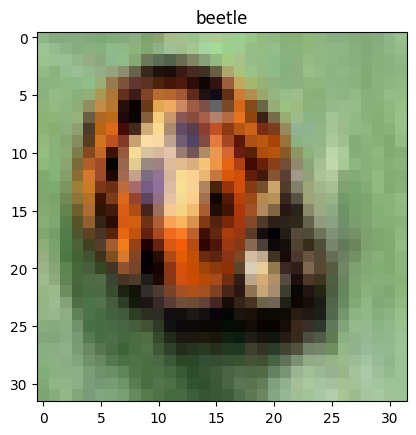

In [469]:
sample = unnormalize_img(test_samples[0].permute(1, 2, 0), mean, std)
plt.imshow(sample)
plt.title(class_names[test_labels[0]])
plt.show()


In [470]:
pred_probs = make_predictions(model=model,
                              data=test_samples)


In [471]:
pred_classses = pred_probs.argmax(dim=1)
pred_classses

tensor([ 7, 63, 64,  5, 69, 51, 70, 61, 62, 23, 32, 43, 14,  2, 16, 77, 56, 27,
        84, 48, 81, 20, 74, 32, 10, 65, 81, 58, 20, 40, 68,  6,  9, 54, 16, 86,
        42, 96, 21, 24, 38, 83, 52, 76, 67, 24, 71, 21, 64, 37, 70,  6, 43, 60,
        40, 92, 76, 43, 22, 33, 27, 49, 23, 23, 65,  9, 15, 83, 69, 61, 33, 23,
        43, 45, 22, 97, 96, 81, 13,  0,  0])

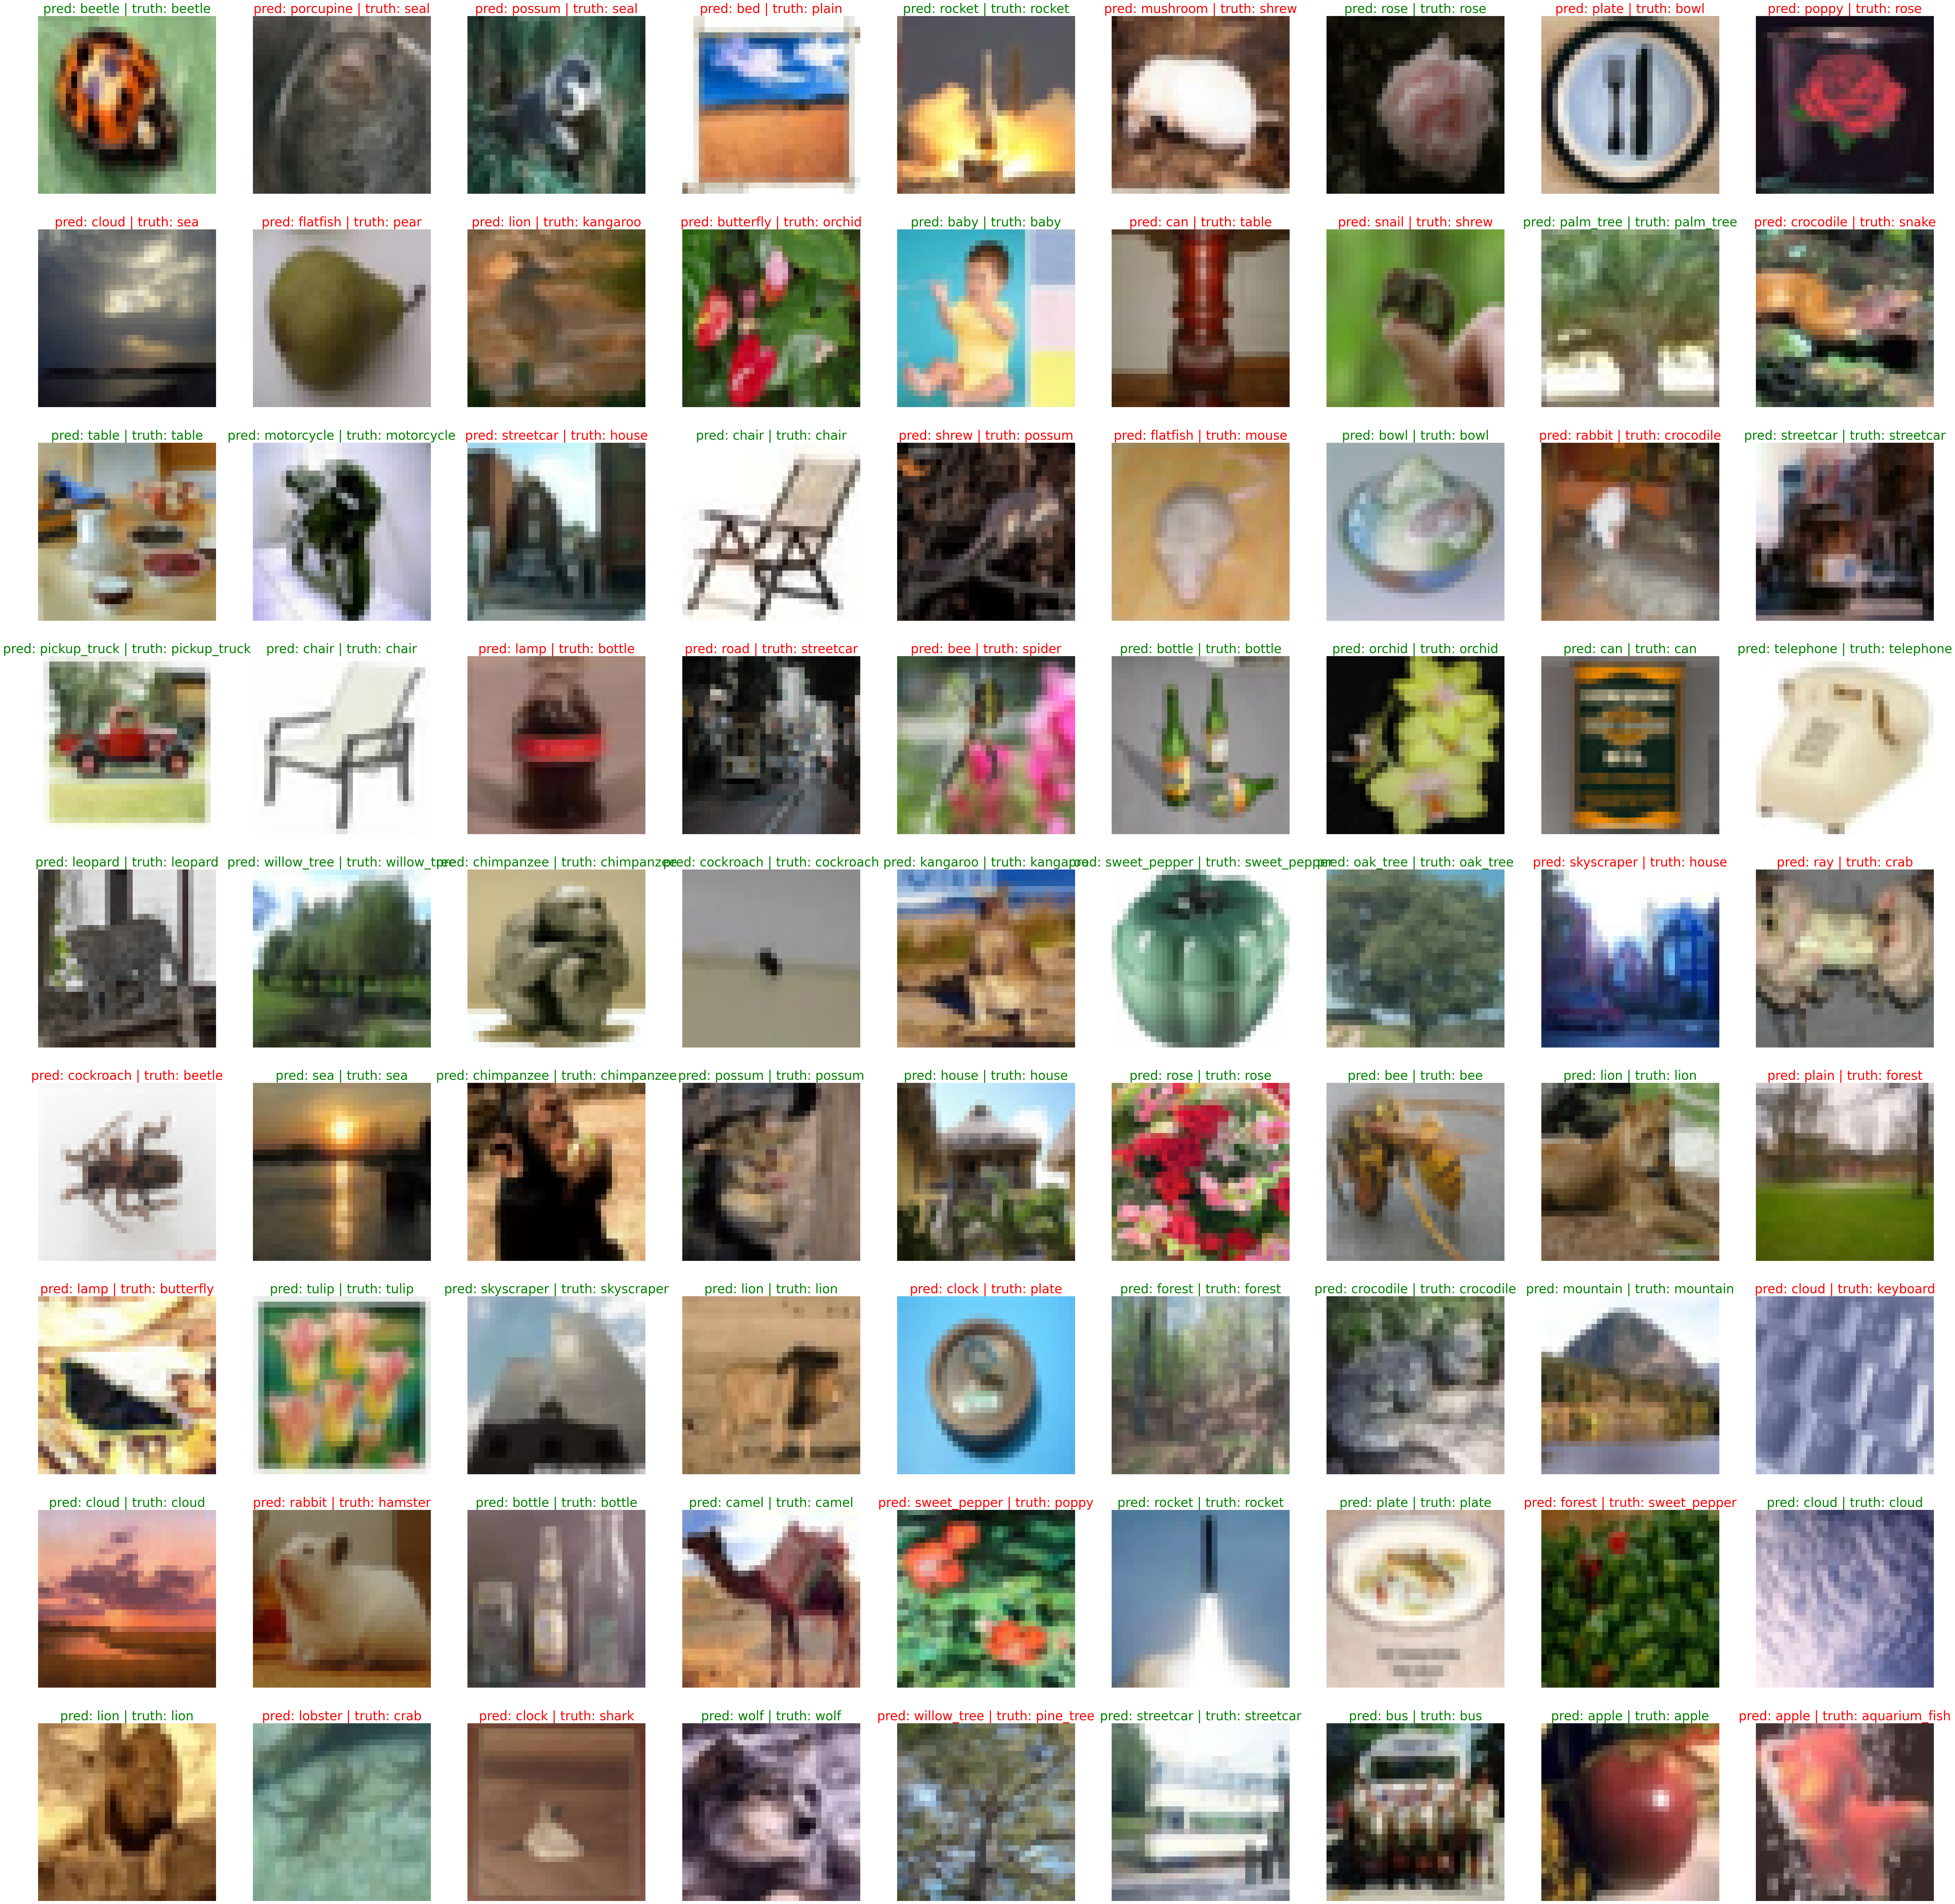

In [472]:
# Plot prediciotns
plt.figure(figsize=(81, 81))
nrows = 9
ncols = 9
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)

    sample = unnormalize_img(sample.permute(1, 2, 0), mean, std)
    plt.imshow(sample)

    #predition label in text form
    pred_label = class_names[pred_classses[i]]

    # get the truth label
    truth_label = class_names[test_labels[i]]

    title_text = f"pred: {pred_label} | truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=30, c="g")
    else:
        plt.title(title_text, fontsize=30, c="r")

    plt.axis(False)

### Saving the model

In [458]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "CIFAR100_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models\CIFAR100_model.pth


### Loading it back

In [459]:
loaded_model = CIFAR100Model(input_shape=3,  # Color channel (image.shape (1))
                           width_multiplier=10,
                           num_classes=len(class_names)).to(device)
MODEL_NAME = "CIFAR100_model_(70_percent_acc).pth"
MODEL_PATH = Path("models")

loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


C:\Users\Nick\AppData\Local\Temp\ipykernel_22240\1834494175.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>